# Mini-Projeto DSA 
## Análise exploratória com SQL e Python


Neste Mini-Projeto tem como função aprender mais sobre o básico da análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Usando dados reais disponíveis publicamente, dados sobre filmes no <a href="https://www.imdb.com/interfaces/">IMDB</a>.

Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Melhores Filmes?
- 10- Quais São os Top 10 Piores Filmes?

## Instala os pacotes

In [2]:
!pip install -q imdb-sqlite
!pip install -q pycountry

## Imports 

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando dados 

In [5]:
%%time
!imdb-sqlite

CPU times: total: 859 ms
Wall time: 1h 20min 43s


2022-10-03 10:08:19,119 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads\name.basics.tsv.gz
2022-10-03 10:08:43,876 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads\title.basics.tsv.gz
2022-10-03 10:09:02,833 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads\title.akas.tsv.gz
2022-10-03 10:09:30,638 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads\title.principals.tsv.gz
2022-10-03 10:10:10,202 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads\title.episode.tsv.gz
2022-10-03 10:10:15,275 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads\title.ratings.tsv.gz
2022-10-03 10:10:16,985 Populating database: imdb.db
2022-10-03 10:10:16,987 Applying schema
2022-10-03 10:10:16,998 Importing file: downloads\name.basics.tsv.gz
2022-10-03 10:10:16,999 Reading number of rows ...
2022-10-03 10:10:27,490 Inserting rows into table: people

  1%|          | 85426/11970635 [00:03<07:23, 26800.05 rows/s]


## Conecta no banco de dados

In [2]:
conn = sqlite3.connect("imdb.db")

## Extrai a lista de tabelas


In [3]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)
type(tabelas)


pandas.core.frame.DataFrame

In [4]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


# Análise Exploratória


## 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
### Quais são os principais tipos (categorias) dos títulos (filmes)?

### Consulta no SQL

In [5]:
consulta = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''
categorias = pd.read_sql_query(consulta, conn)
display(categorias)

,type,COUNT
0,movie,622830
1,short,892396
2,tvEpisode,6990140
3,tvMiniSeries,45383
4,tvMovie,137748
5,tvPilot,2
6,tvSeries,231970
7,tvShort,10690
8,tvSpecial,38588
9,video,265766


### Percentual das categorias

In [6]:
categorias['percentual'] = (categorias['COUNT'] / categorias['COUNT'].sum()) * 100
display(categorias)

,type,COUNT,percentual
0,movie,622830,6.720295
1,short,892396,9.628894
2,tvEpisode,6990140,75.423152
3,tvMiniSeries,45383,0.489680
4,tvMovie,137748,1.486292
5,tvPilot,2,0.000022
6,tvSeries,231970,2.502941
7,tvShort,10690,0.115344
8,tvSpecial,38588,0.416362
9,video,265766,2.867598



### Filtragem das 3 categorias com mais títulos e 1 categoria com todo o restante

In [7]:
# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = categorias[categorias['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = categorias[categorias['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'

In [8]:
display(others)

{'COUNT': 762531, 'percentual': 8.22765941399651, 'type': 'others'}

In [9]:
# Filtra o dataframe de resultado
categorias = categorias[categorias['percentual'] > 5]

# Append com o dataframe de outras categorias
categorias = categorias.append(others, ignore_index = True)

# Ordena o resultado
categorias = categorias.sort_values(by = 'COUNT', ascending = False)

# Visualiza
categorias.head()

,type,COUNT,percentual
2,tvEpisode,6990140,75.423152
1,short,892396,9.628894
3,others,762531,8.227659
0,movie,622830,6.720295


### Visualização em Gráfico

In [10]:
# Ajusta os legendas
labels = [str(categorias['type'][i])+' '+'['+str(round(categorias['percentual'][i],2)) +'%'+']' for i in categorias.index]

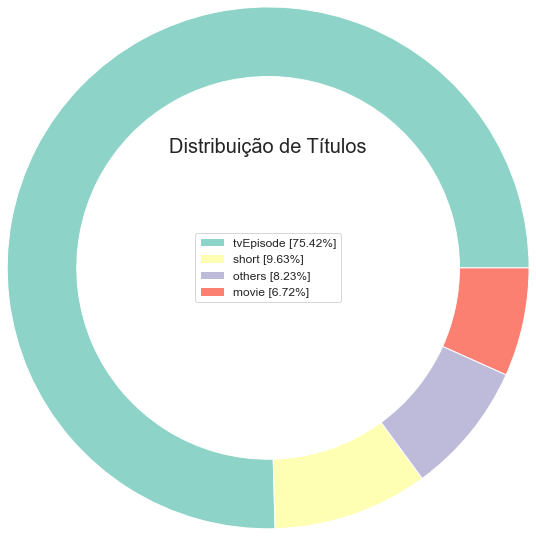

In [11]:
# Plot
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(categorias['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## 2- Qual o Número de Títulos Por Gênero?
### Vamos calcular o número de filmes por gênero em valor percentual.

### Consulta SQL

In [12]:
generos = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 
generos = pd.read_sql_query(generos, conn)
display(generos)

,genres,COUNT(*)
0,Action,14196
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1463,"Thriller,Western",42
1464,War,1315
1465,"War,Western",14
1466,Western,5156


In [13]:
# Convertendo strings para minúsculo
generos['genres'] = generos['genres'].str.lower().values

In [14]:
# dropa NA
noNA = generos['genres'].dropna()

### Usando a função Countvectorizer para converter a coluna de gênero em um vetor one-hot encoded para contar os números de filmes em cada gêncero.

In [16]:
# Vamos criar um vetor usando expressão regular para filtrar as strings
# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(noNA)

In [17]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(noNA)

In [24]:
# Retorna gêneros
generos_unicos =  vetor.get_feature_names()
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = noNA.index)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [25]:
# Coluna n drop
generos = generos.drop(columns = 'n', axis = 0)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  news         1468 non-null   int64
 19  reality-tv   1468 non-null   int64
 20  romance 

In [27]:
# Percentual de generos de filmes
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]
generos_percentual.head(10)

drama          17.915531
comedy         17.029973
documentary    16.008174
adventure      14.782016
action         14.509537
romance        13.283379
crime          13.010899
mystery        12.329700
thriller       12.261580
horror         12.193460
dtype: float64

### Vizualização gráfico

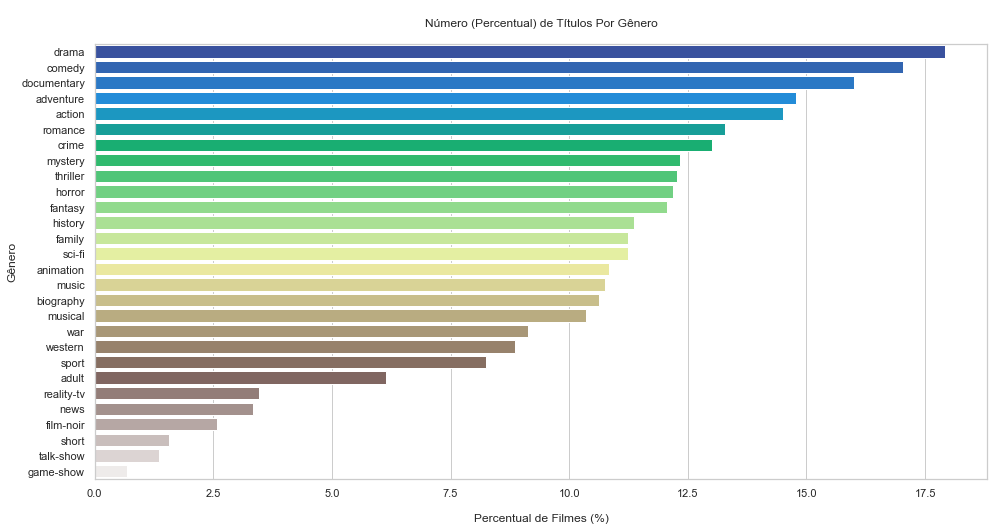

In [28]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
### Mediana de avaliação dos filmes.

### Consulta no SQL

In [32]:
avaliacao = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 
avaliacao = pd.read_sql_query(avaliacao, conn)
display(avaliacao)

,rating,genres
0,5.2,Romance
1,3.7,\N
2,6.0,"Action,Adventure,Biography"
3,4.0,Drama
4,4.1,Drama
...,...,...
282930,5.8,Thriller
282931,6.4,"Drama,History"
282932,3.8,"Adventure,History,War"
282933,8.3,Drama


### Função para retornar os genêros

In [30]:

def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [37]:
generos_unicos = retorna_generos(avaliacao)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [39]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    #calcula mediana
    genero_ratings.append(np.median(resultado['rating']))

In [42]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

df_genero_ratings.head(20)

,genres,count,rating
0,action,29288,5.80
1,adult,4417,5.80
2,adventure,17707,6.00
3,animation,4858,6.60
4,biography,8655,7.00
5,comedy,69817,6.00
6,crime,24233,6.10
7,documentary,42614,7.30
8,drama,125413,6.30
9,family,10889,6.30


In [45]:
# Ordenando o Resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

### Visualização em Gráfico

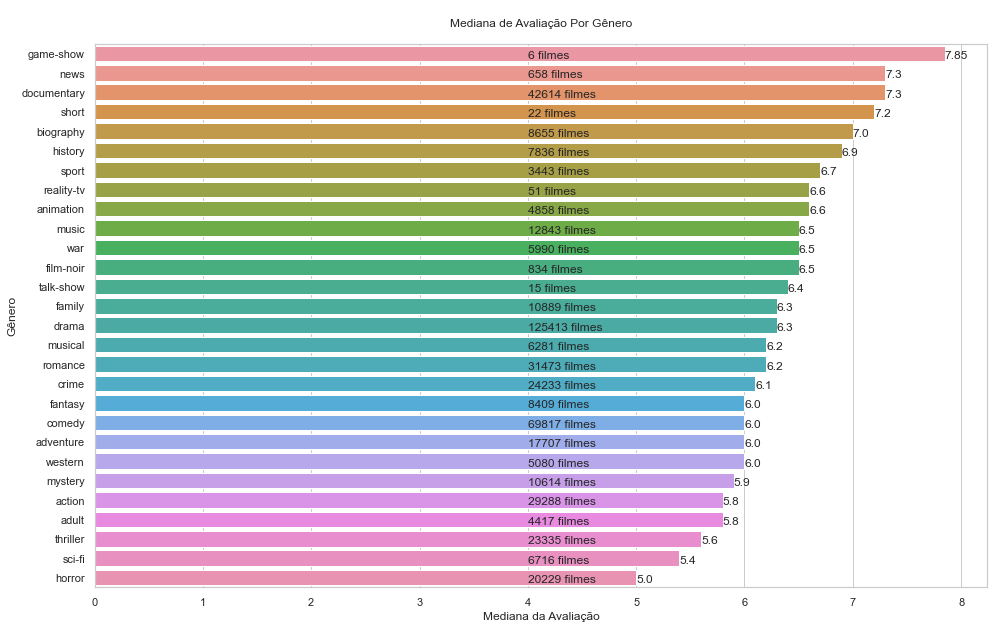

In [46]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()